# **Carga y Exploración de Datos**


## **Objetivo** 

Comprender la estructura, distribución y relaciones en el dataset mediante:

- Análisis estadístico descriptivo

- Visualización de distribuciones

- Identificación de patrones iniciales

## **Dataset**

El conjunto de datos proviene del UCI Machine Learning Repository y contiene información sobre:

- Características demográficas

- Historial académico previo

- Desempeño durante el semestre

- Resultados finales (abandono y calificaciones)

## **Librerías**

In [2]:
# Importación de librerías (celda de código)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report,
                           mean_absolute_error, mean_squared_error, r2_score)
from sklearn.metrics import roc_curve, auc

## **Importación de los datos**

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 
  
# metadata 
print(predict_students_dropout_and_academic_success.metadata) 
  
# variable information 
print(predict_students_dropout_and_academic_success.variables) 


{'uci_id': 697, 'name': "Predict Students' Dropout and Academic Success", 'repository_url': 'https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success', 'data_url': 'https://archive.ics.uci.edu/static/public/697/data.csv', 'abstract': "A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies.\nThe dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. \nThe data is used to build classification models to predict students' dropout and academic sucess. The problem is formulated as a three category classification task, in which there is a strong imbalance towards one of the classes.", 'area': 'Social Sc

## **Análisis Exploratorio de los datos (EDA)**

### **Análisis Inicial**

In [4]:
# Carga de datos
data = fetch_ucirepo(id=697)
df = pd.concat([data.data.features, data.data.targets], axis=1)

# 1.1. Análisis inicial
print("Información básica:")
print(f"- Dimensiones: {df.shape}")
print(f"- Variables: {len(df.columns)}")
print(f"- Valores faltantes: {df.isnull().sum().sum()}")

Información básica:
- Dimensiones: (4424, 37)
- Variables: 37
- Valores faltantes: 0


### **Distribución de Variable Objetivo (Clasificación)**

Estadísticas del promedio académico:
count    4424.000000
mean       10.435514
std         4.818530
min         0.000000
25%        11.000000
50%        12.250000
75%        13.266667
max        18.283654
Name: Average_grade, dtype: float64


Text(0, 0.5, 'Cantidad de Estudiantes')

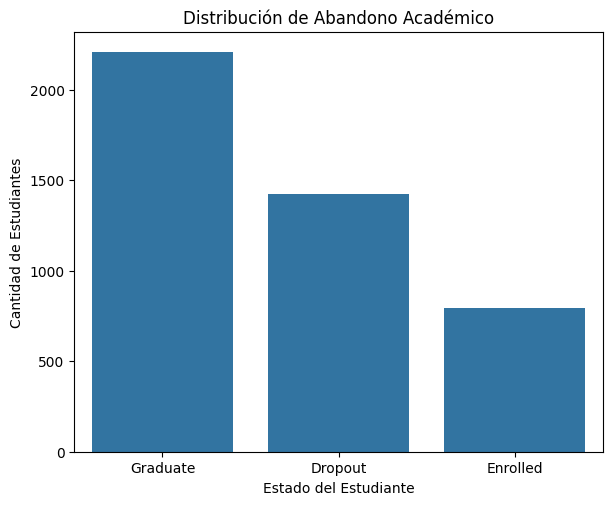

In [5]:

df['Average_grade'] = (df['Curricular units 1st sem (grade)'] + df['Curricular units 2nd sem (grade)']) / 2


print("Estadísticas del promedio académico:")
print(df['Average_grade'].describe())

df_clean = df.dropna(subset=['Average_grade', 'Target']).copy()

#Visualización
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
sns.countplot(data=df, x='Target', order=df['Target'].value_counts().index)
plt.title('Distribución de Abandono Académico')
plt.xlabel('Estado del Estudiante')
plt.ylabel('Cantidad de Estudiantes')

### **Distribución del promedio** 

Text(10.535513648948914, 1204.875, 'Media')

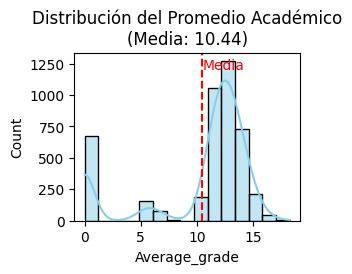

In [6]:
plt.subplot(2, 2, 2)
ax = sns.histplot(data=df_clean, x='Average_grade', bins=15, kde=True, color='skyblue')
plt.title('Distribución del Promedio Académico\n(Media: {:.2f})'.format(df_clean['Average_grade'].mean()))
plt.axvline(df_clean['Average_grade'].mean(), color='red', linestyle='--')
plt.text(df_clean['Average_grade'].mean()+0.1, ax.get_ylim()[1]*0.9, 'Media', color='red')

#### **Distribución por semestre**

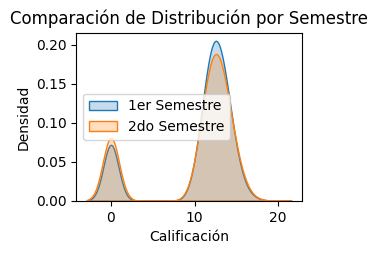

In [7]:
plt.subplot(2, 2, 3)
sns.kdeplot(data=df, x='Curricular units 1st sem (grade)', label='1er Semestre', fill=True)
sns.kdeplot(data=df, x='Curricular units 2nd sem (grade)', label='2do Semestre', fill=True)
plt.title('Comparación de Distribución por Semestre')
plt.xlabel('Calificación')
plt.ylabel('Densidad')
plt.legend()

### **Boxplot**

C:\Users\Elian\AppData\Local\Temp\ipykernel_34360\4238463372.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='Target', y='Average_grade', palette='Set2',


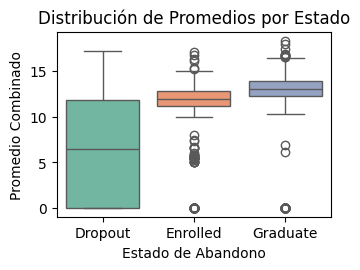

In [8]:
plt.subplot(2, 2, 4)
sns.boxplot(data=df_clean, x='Target', y='Average_grade', palette='Set2',
           order=sorted(df_clean['Target'].unique()))
plt.title('Distribución de Promedios por Estado')
plt.xlabel('Estado de Abandono')
plt.ylabel('Promedio Combinado')

plt.tight_layout()
plt.show()

## **Clasificación de las variables y preprocesamiento**

Basado en la descripción del dataset, clasificaré las variables en categóricas y numéricas, y luego crearé un pipeline adecuado para el preprocesamiento.

### **Clasificación de variables**

In [9]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Definición de columnas por tipo
categorical_features = [
    'Marital Status', 'Application mode', 'Course', 
    'Daytime/evening attendance', 'Previous qualification',
    'Nacionality', "Mother's qualification", "Father's qualification",
    "Mother's occupation", "Father's occupation", 'Displaced',
    'Educational special needs', 'Debtor', 'Tuition fees up to date',
    'Gender', 'Scholarship holder', 'International'
]

numeric_features = [
    'Application order', 'Previous qualification (grade)',
    'Admission grade', 'Age at enrollment',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate', 'Inflation rate', 'GDP'
]

# Transformers para cada tipo de variable
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())  # Normalización MinMax para variables numéricas
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # OneHot para categóricas
])

# Combinar transformers en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Ignorar cualquier otra columna no especificada
)

# Pipeline completo (puedes añadir el estimador al final)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
    # ('classifier', ...)  # Aquí iría tu modelo KNN u otro
])

### **Análisis estadístico por tipo de varibale** 

#### **Variables numéricas**

       Application order  Previous qualification (grade)  Admission grade  \
count        4424.000000                     4424.000000      4424.000000   
mean            1.727848                      132.613314       126.978119   
std             1.313793                       13.188332        14.482001   
min             0.000000                       95.000000        95.000000   
25%             1.000000                      125.000000       117.900000   
50%             1.000000                      133.100000       126.100000   
75%             2.000000                      140.000000       134.800000   
max             9.000000                      190.000000       190.000000   

       Age at enrollment  Curricular units 1st sem (credited)  \
count        4424.000000                          4424.000000   
mean           23.265145                             0.709991   
std             7.587816                             2.360507   
min            17.000000                      

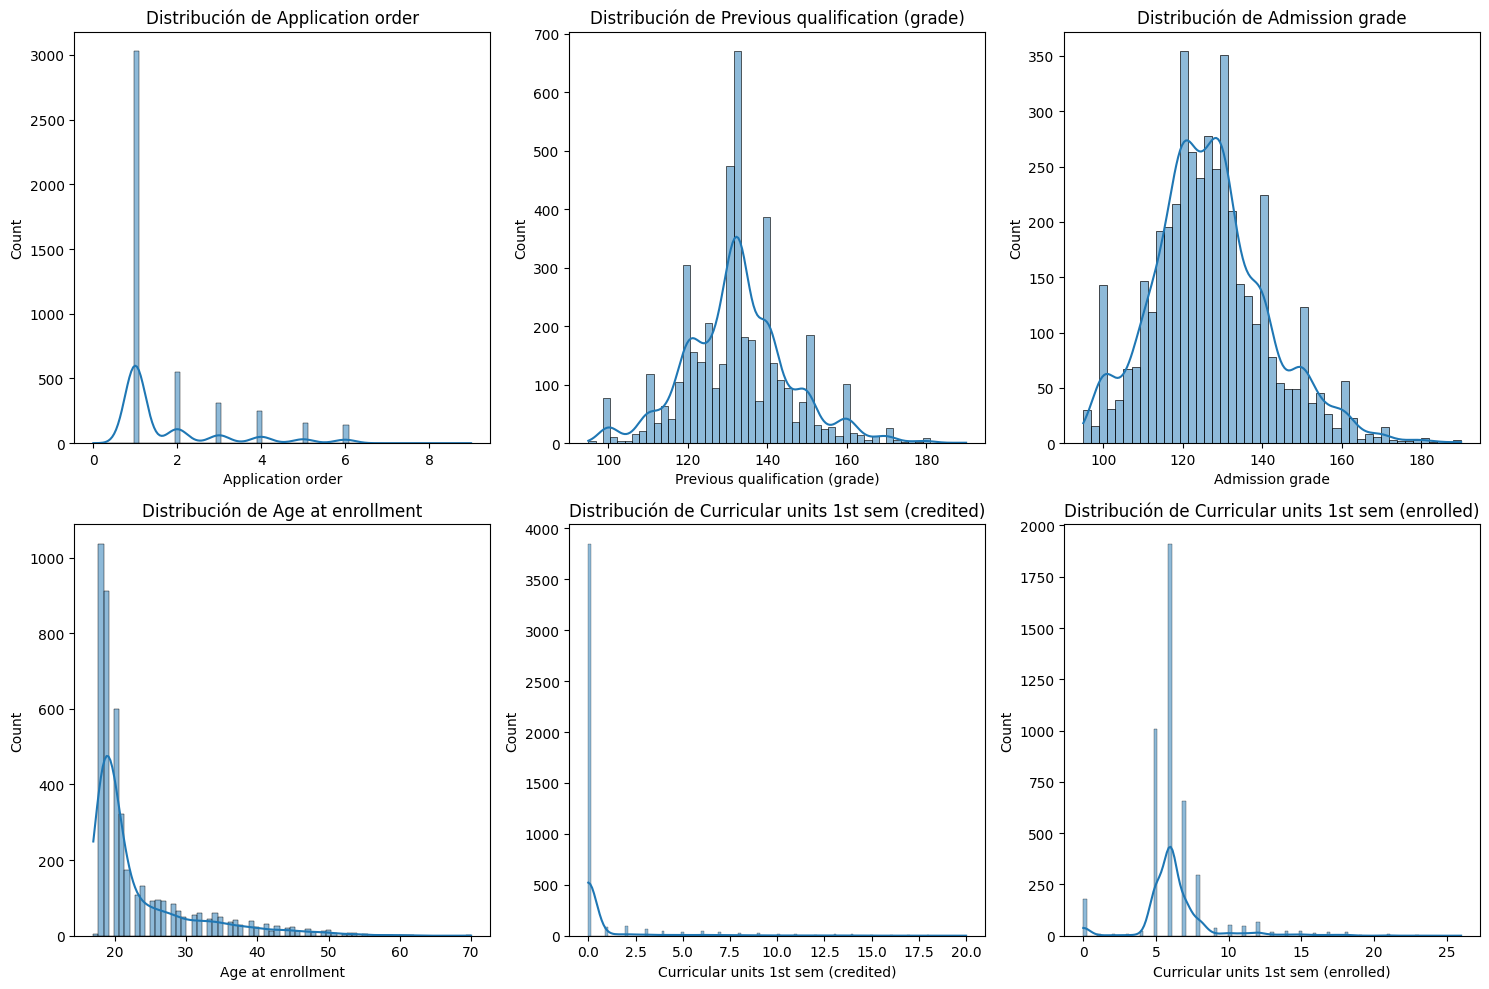

In [10]:
# Estadísticas descriptivas
print(df[numeric_features].describe())

# Visualización
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features[:6]):  # Mostrar solo las primeras 6 para ejemplo
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

#### **Variables categóricas**

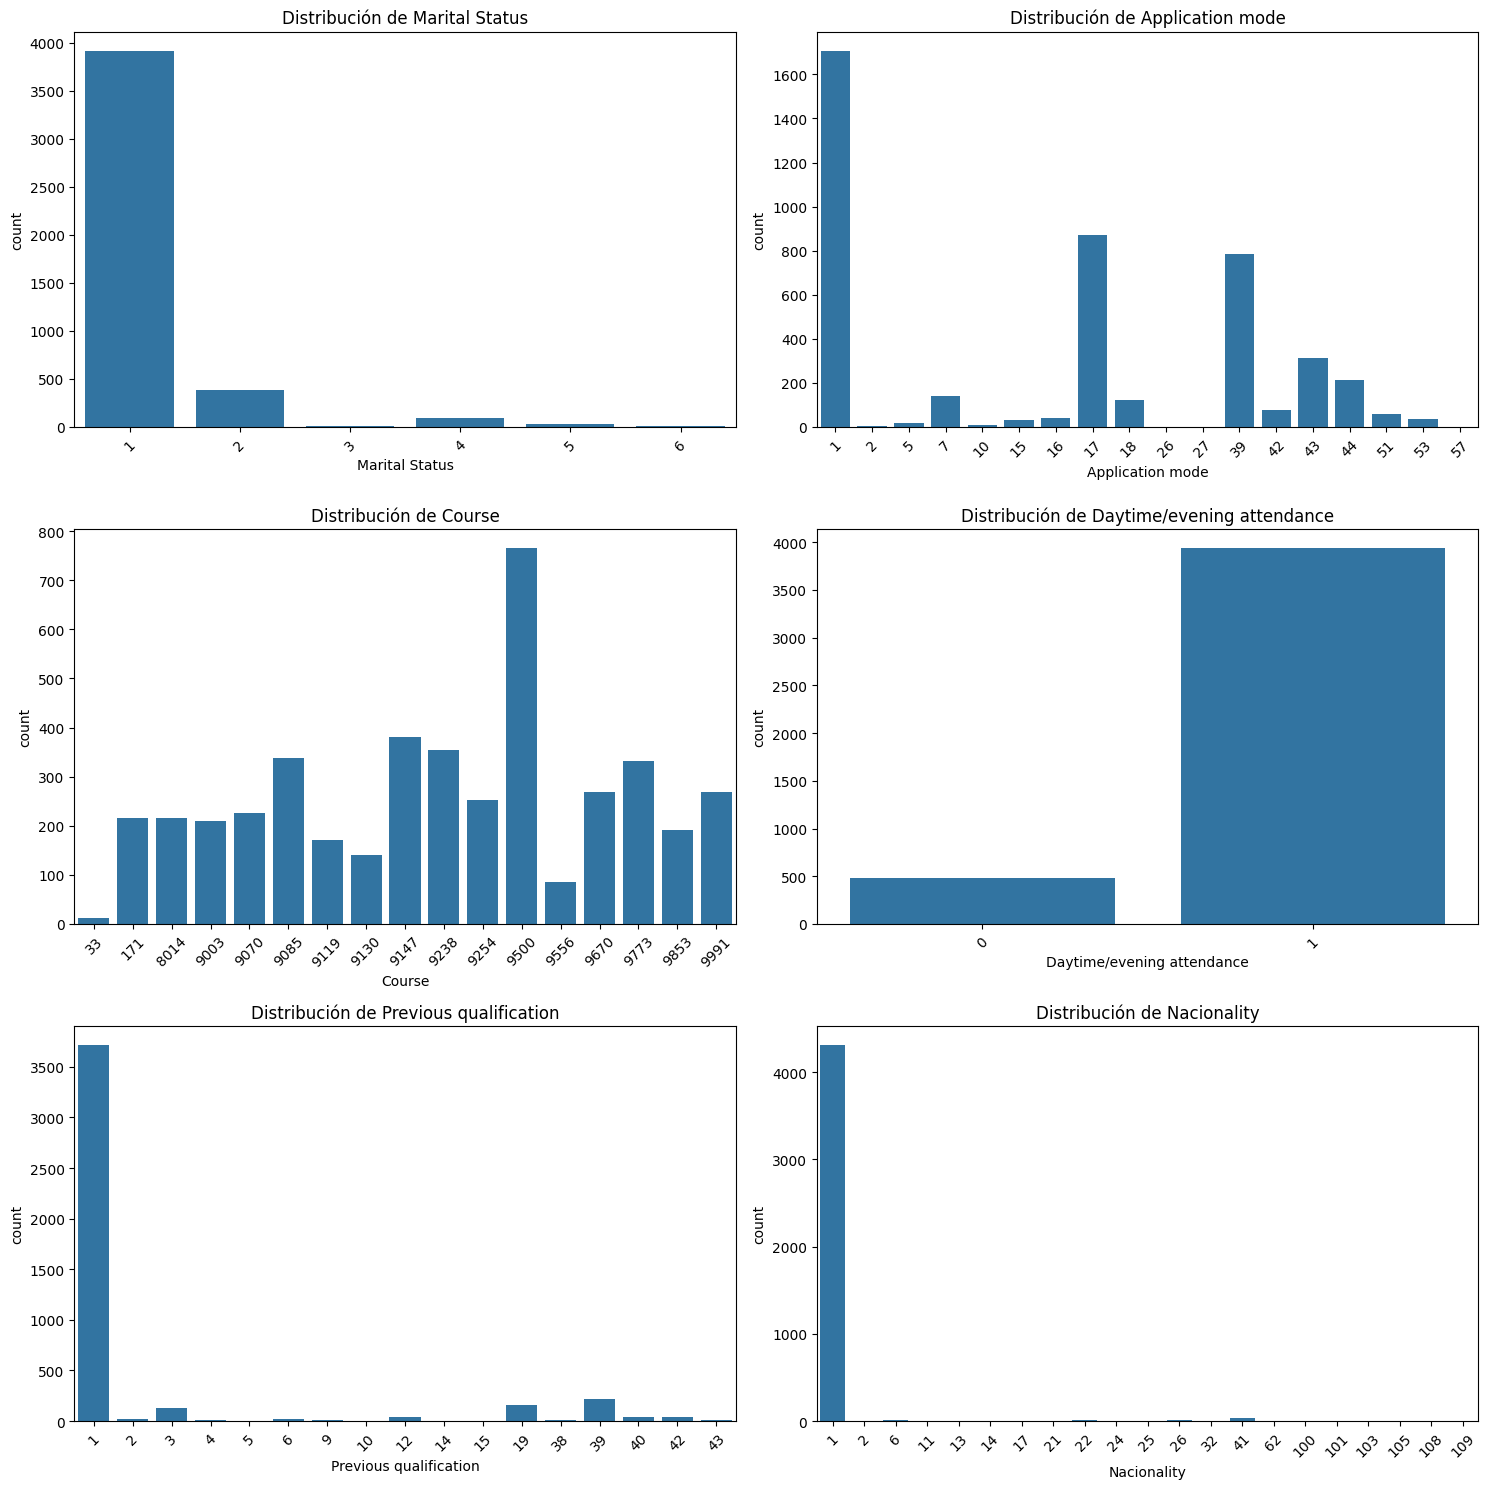

In [11]:
# Frecuencias y visualización
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_features[:6]):  # Mostrar solo las primeras 6 para ejemplo
    plt.subplot(3, 2, i+1)
    sns.countplot(data=df, x=col)
    plt.title(f'Distribución de {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Implementación completa del modelo KNN**

## **División de los datos**

In [12]:
from sklearn.model_selection import train_test_split

# Definir variables (ajustar según tus nombres de columnas exactos)
X = df.drop('Target', axis=1)  # Features
y_class = df['Target']  # Clasificación
y_reg = df['Curricular units 2nd sem (grade)']  # Regresión

# División para clasificación (70% train, 30% test)
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_class, test_size=0.3, random_state=42, stratify=y_class)

# División para regresión (mismos splits para consistencia)
_, _, y_reg_train, y_reg_test = train_test_split(
    X, y_reg, test_size=0.3, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

Tamaño del conjunto de entrenamiento: 3096 muestras
Tamaño del conjunto de prueba: 1328 muestras


## **KNN para clasificación**

### **Entrenamiento y Evaluación**


Classification Report:
              precision    recall  f1-score   support

     Dropout       0.66      0.56      0.60       427
    Enrolled       0.31      0.24      0.27       238
    Graduate       0.66      0.77      0.71       663

    accuracy                           0.61      1328
   macro avg       0.54      0.52      0.53      1328
weighted avg       0.60      0.61      0.60      1328



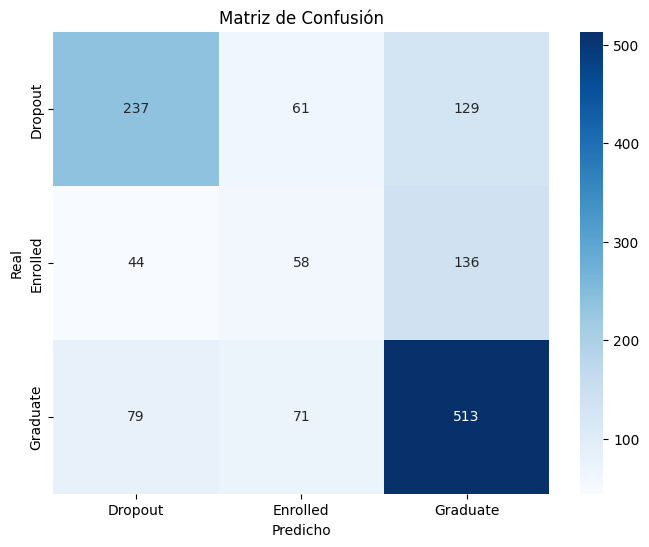

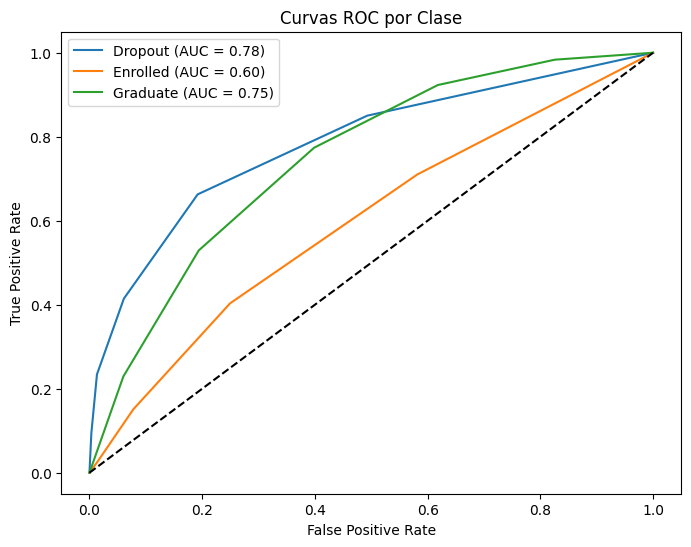

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, classification_report, 
                           roc_curve, auc, RocCurveDisplay)

# Crear y entrenar modelo (usando k=5 como ejemplo)
knn_class = KNeighborsClassifier(n_neighbors=5)
knn_class.fit(preprocessor.fit_transform(X_train), y_class_train)

# Predecir en test
y_pred = knn_class.predict(preprocessor.transform(X_test))
y_proba = knn_class.predict_proba(preprocessor.transform(X_test))

# Métricas
print("\nClassification Report:")
print(classification_report(y_class_test, y_pred))

# Matriz de Confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_class_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=knn_class.classes_, yticklabels=knn_class.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# Curva ROC (para clasificación multiclase)
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(knn_class.classes_):
    fpr, tpr, _ = roc_curve(y_class_test == class_label, y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC por Clase')
plt.legend()
plt.show()

### **Evaluación con diferentes modelos de *k***

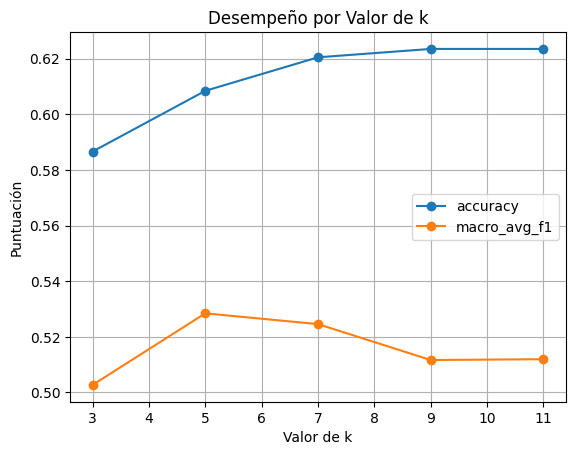

In [14]:
k_values = [3, 5, 7, 9, 11]
results = {}

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(preprocessor.transform(X_train), y_class_train)
    y_pred = model.predict(preprocessor.transform(X_test))
    report = classification_report(y_class_test, y_pred, output_dict=True)
    results[k] = {
        'accuracy': report['accuracy'],
        'macro_avg_f1': report['macro avg']['f1-score']
    }

# Visualización
results_df = pd.DataFrame(results).T
results_df.plot(marker='o')
plt.title('Desempeño por Valor de k')
plt.xlabel('Valor de k')
plt.ylabel('Puntuación')
plt.grid(True)
plt.show()

## **KNN para Regresión**

### **Entrenamiento y evaluación**


Métricas de Regresión:
MAE: 4.34
RMSE: 5.74
R²: -0.20


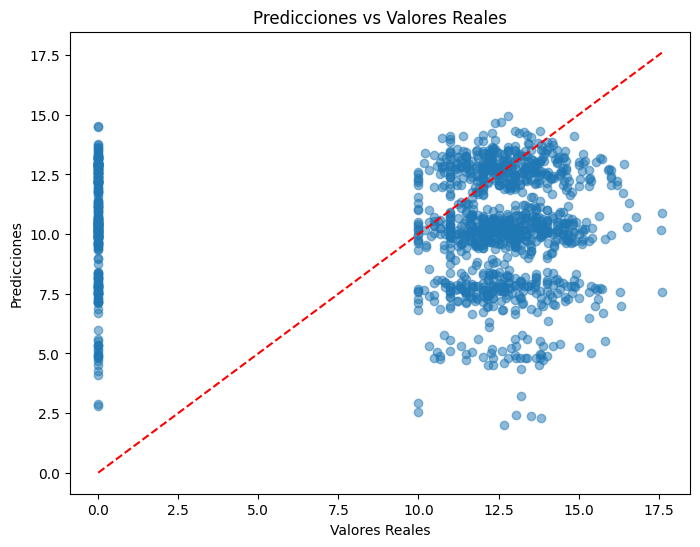

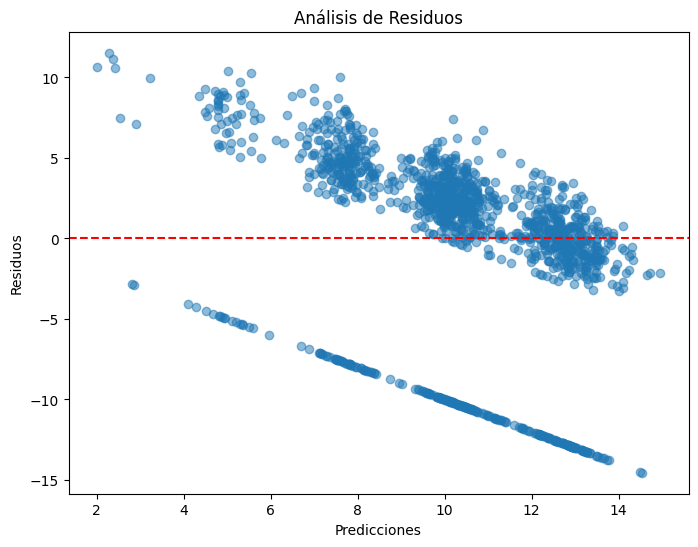

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Crear y entrenar modelo (k=5 como ejemplo)
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(preprocessor.transform(X_train), y_reg_train)

# Predecir
y_pred_reg = knn_reg.predict(preprocessor.transform(X_test))

# Métricas
print("\nMétricas de Regresión:")
print(f"MAE: {mean_absolute_error(y_reg_test, y_pred_reg):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_reg_test, y_pred_reg)):.2f}")
print(f"R²: {r2_score(y_reg_test, y_pred_reg):.2f}")

# Gráfico de predicciones vs reales
plt.figure(figsize=(8, 6))
plt.scatter(y_reg_test, y_pred_reg, alpha=0.5)
plt.plot([y_reg_test.min(), y_reg_test.max()], 
         [y_reg_test.min(), y_reg_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

# Gráfico de residuos
residuals = y_reg_test - y_pred_reg
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_reg, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Análisis de Residuos')
plt.show()

### **Evaluación con diferentes modelos de *k***

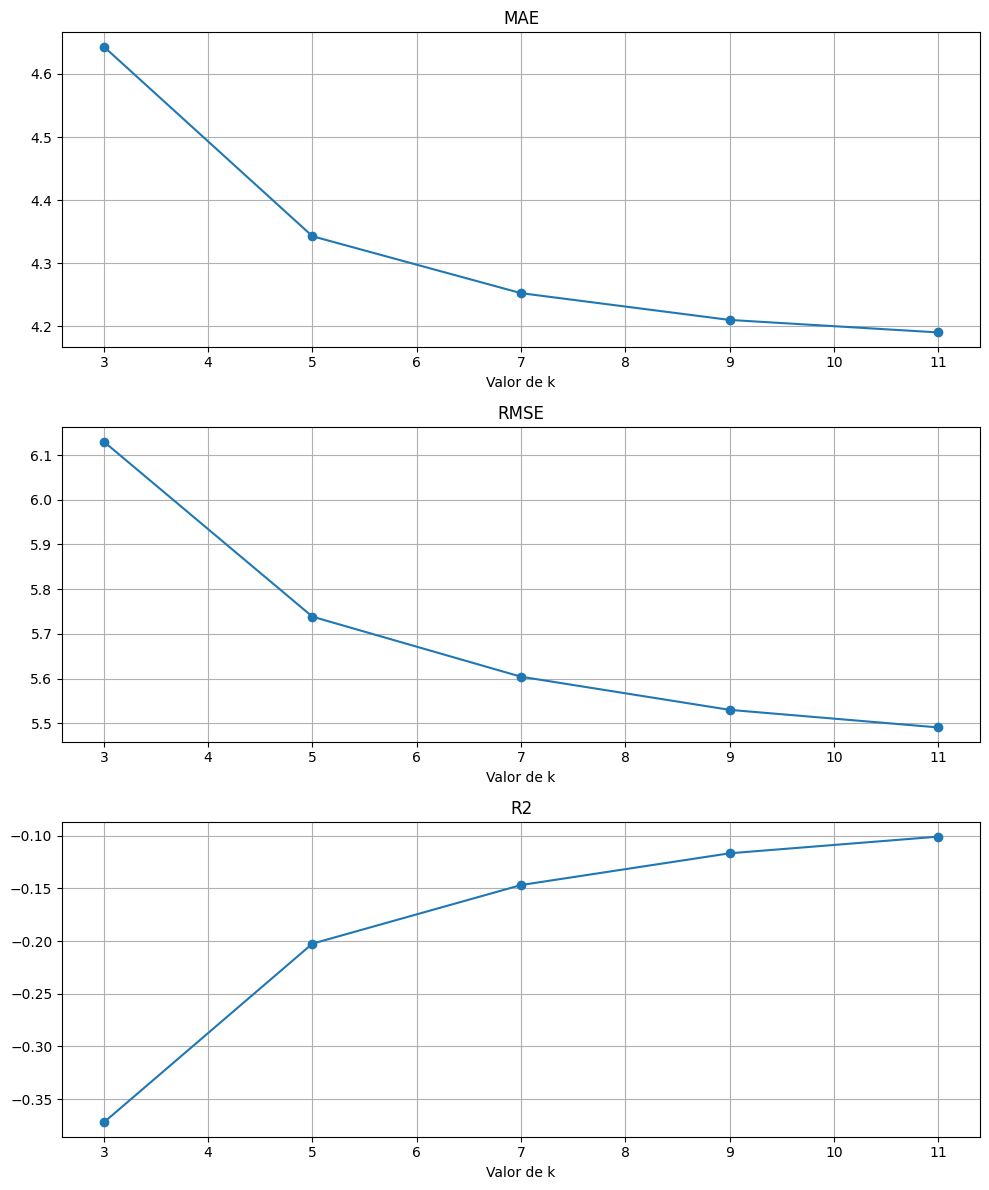

In [16]:
reg_results = {}

for k in k_values:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(preprocessor.transform(X_train), y_reg_train)
    y_pred = model.predict(preprocessor.transform(X_test))
    reg_results[k] = {
        'MAE': mean_absolute_error(y_reg_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_reg_test, y_pred)),
        'R2': r2_score(y_reg_test, y_pred)
    }

# Visualización
reg_results_df = pd.DataFrame(reg_results).T
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for i, metric in enumerate(['MAE', 'RMSE', 'R2']):
    reg_results_df[metric].plot(ax=axes[i], marker='o')
    axes[i].set_title(metric)
    axes[i].set_xlabel('Valor de k')
    axes[i].grid(True)
plt.tight_layout()
plt.show()

# **Documentación de resultados**

## **Para clasificación**

In [17]:
print("Resumen de Clasificación:")
print(f"Mejor k: {results_df['accuracy'].idxmax()} con accuracy {results_df['accuracy'].max():.3f}")
print("\nMatriz de Confusión óptima:")
best_k_class = results_df['accuracy'].idxmax()
best_model = KNeighborsClassifier(n_neighbors=best_k_class)
best_model.fit(preprocessor.transform(X_train), y_class_train)
y_pred_best = best_model.predict(preprocessor.transform(X_test))
print(confusion_matrix(y_class_test, y_pred_best))

Resumen de Clasificación:
Mejor k: 9 con accuracy 0.623

Matriz de Confusión óptima:
[[229  47 151]
 [ 41  35 162]
 [ 51  48 564]]


## **Para Regresión**

In [18]:
print("\nResumen de Regresión:")
print(f"Mejor k: {reg_results_df['R2'].idxmax()} con R² {reg_results_df['R2'].max():.3f}")
print(f"Menor RMSE: {reg_results_df['RMSE'].min():.3f} con k={reg_results_df['RMSE'].idxmin()}")


Resumen de Regresión:
Mejor k: 11 con R² -0.101
Menor RMSE: 5.491 con k=11


# **Conclusiones**